## Part I: Model Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define constants
EMBEDDING_DIM = 16
HIDDEN_DIM = 16
LATENT_DIM = 16 # Dimension of the latent space
SEQ_LEN = 16 # Max length of the sequence

# Gumbel softmax temperature
TAU = 1.0

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
torch.random.manual_seed(1024)

In [3]:
# Pass embeded into decoder instead of using the original x
class TransformerEncoder(nn.Module):
    def __init__(self, d_model=EMBEDDING_DIM, nhead=4, num_layers=2):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_layers
        )
        self.fc_logits = nn.Linear(d_model, LATENT_DIM)

    def forward(self, x):
        embedded = self.embedding(x).permute(1, 0, 2)  # Transformer expects seq_len, batch, features
        transformed = self.transformer_encoder(embedded)
        # Use the final state to predict logits for latent space
        logits = self.fc_logits(transformed[-1])
        return logits, embedded


class TransformerDecoder(nn.Module):
    def __init__(self, d_model=EMBEDDING_DIM, nhead=4, num_layers=2):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead), num_layers
        )
        self.fc_out = nn.Linear(d_model, VOCAB_SIZE)
        self.fc_z = nn.Linear(LATENT_DIM, d_model)  # Convert z to feature size for transformer

    def forward(self, embedded, z):
        # embedded = self.embedding(x).permute(1, 0, 2) # Transformer expects [seq_len, batch, features], permute函数用于改变张量的维度顺序
        z_adjusted = self.fc_z(z).unsqueeze(0)
        output = self.transformer_decoder(embedded, z_adjusted)
        return self.fc_out(output.permute(1, 0, 2))


class TransformerCVAE(nn.Module):
    def __init__(self):
        super(TransformerCVAE, self).__init__()
        self.encoder = TransformerEncoder()
        self.decoder = TransformerDecoder()

    def reparameterize(self, logits):
        return F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1)

    def forward(self, x):
        logits, emb = self.encoder(x)
        z = self.reparameterize(logits)
        return self.decoder(emb, z), logits

In [4]:
def load_and_preprocess_wikitext(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Use regular expressions to split the text into sentences
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [sentence.strip() for sentence in sentences]
    
    return sentences

train_file_path = "wikitext-2/wiki.train.tokens"
test_file_path = "wikitext-2/wiki.test.tokens"
val_file_path = "wikitext-2/wiki.valid.tokens"

wikitext_sentences_train = load_and_preprocess_wikitext(train_file_path)
wikitext_sentences_test = load_and_preprocess_wikitext(test_file_path)
wikitext_sentences_val = load_and_preprocess_wikitext(val_file_path)

# Print the first few sentences to check
print("\nSample of train sentences:")
print(wikitext_sentences_train[:5])
print("\nSample of test sentences:")
print(wikitext_sentences_test[:5])
print("\nSample of val sentences:")
print(wikitext_sentences_val[:5])


Sample of train sentences:
['= Valkyria Chronicles III = \n \n Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit .', 'Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable .', 'Released in January 2011 in Japan , it is the third game in the Valkyria series .', '<unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .', 'The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II .']

Sample of test sentences:
['= Robert <unk> = \n \n Robert <unk> is an English film , television and theatre actor .',

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

# Hyperparameters
BATCH_SIZE = 32
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Tokenize the data
tokens = [word for sentence in wikitext_sentences_train for word in sentence.split()]

# Build vocabulary
vocab = [PAD_TOKEN, UNK_TOKEN] + list(set(tokens))
word_index = {word: index for index, word in enumerate(vocab)}
# 添加新的tokens
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
word_index[SOS_TOKEN] = len(word_index)
word_index[EOS_TOKEN] = len(word_index)
vocab = {v: k for k, v in word_index.items()}
# Convert tokens to integers
def tokenize_and_encode(text):
    return [word_index.get(word, word_index[UNK_TOKEN]) for word in text.split()]

encoded_data_train = [tokenize_and_encode(sentence) for sentence in wikitext_sentences_train]

# Create a PyTorch Dataset
class WikiDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if len(sample) < self.sequence_length:
            sample.extend([word_index[PAD_TOKEN]] * (self.sequence_length - len(sample)))
        else:
            sample = sample[:self.sequence_length]
        return torch.tensor(sample)

# dataset = WikiDataset(encoded_data_train, SEQUENCE_LENGTH)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# Split the data into train and validation sets
dataset = WikiDataset(encoded_data_train, SEQ_LEN)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Display a sample batch
next(iter(train_dataloader))

VOCAB_SIZE = len(vocab)
print(f'Vocabulary size: {VOCAB_SIZE}')


Vocabulary size: 33281


In [6]:
# Initializing the model with the set hyperparameters
transformer_cvae = TransformerCVAE()
transformer_cvae.to(device)

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_cvae.parameters(), lr=1e-3)

Epoch 1/3 | Loss: 2.0958877 = Recon: 2.0869696 + KLD: 0.0008918:  33%|███▎      | 1964/5892 [06:42<2:08:55,  1.97s/it]  

Done Epoch [1/3] - Loss: 6.1123295
Done Epoch [1/3] - Validation Loss: 1.4346660


Epoch 2/3 | Loss: 1.3853493 = Recon: 1.3819441 + KLD: 0.0003405:  33%|███▎      | 1965/5892 [07:05<8:49:26,  8.09s/it]

Input: There were several variants of the <unk> design . ---> Echo: There were several Police of the <unk> design .



Epoch 2/3 | Loss: 0.6075547 = Recon: 0.6059898 + KLD: 0.0001565:  67%|██████▋   | 3928/5892 [13:27<06:14,  5.24it/s]  

Done Epoch [2/3] - Loss: 0.8867921
Done Epoch [2/3] - Validation Loss: 0.7056456
Input: There were several variants of the <unk> design . ---> Echo: There were several variants of the <unk> design .



Epoch 3/3 | Loss: 0.3313146 = Recon: 0.3302265 + KLD: 0.0001088: 100%|██████████| 5892/5892 [19:33<00:00,  5.59it/s]  

Done Epoch [3/3] - Loss: 0.4251207


Epoch 3/3 | Loss: 0.3313146 = Recon: 0.3302265 + KLD: 0.0001088: 100%|██████████| 5892/5892 [19:48<00:00,  4.96it/s]

Done Epoch [3/3] - Validation Loss: 0.4694043
Input: There were several variants of the <unk> design . ---> Echo: There were several variants of the <unk> design .



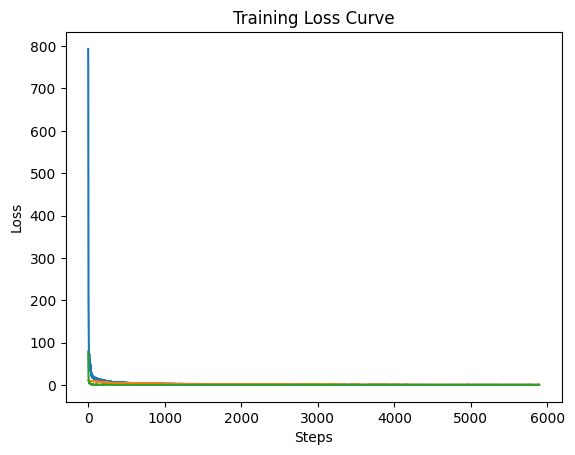

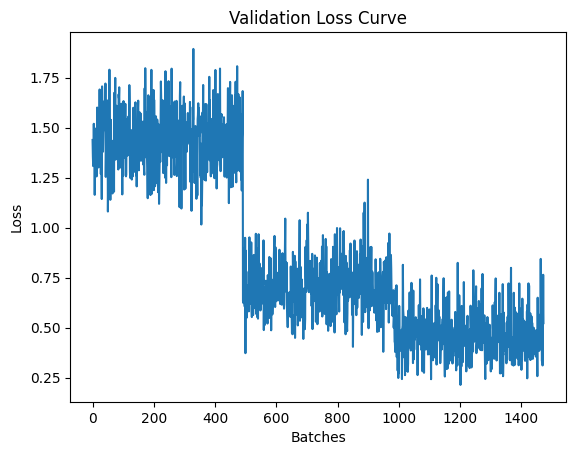

In [7]:
def generate_text(model, sentence, vocab):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Tokenize and encode the sentence
        encoded_sentence = tokenize_and_encode(sentence)
        input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)  # Ensure type is Long
        
        # Pass the encoded sentence through the model encoder
        with torch.no_grad():
            logits, emb = model.encoder(input_tensor)
            z = model.reparameterize(logits)
            output = model.decoder(emb, z)
        
        # Convert the output probabilities to predicted token IDs
        _, predicted_ids = torch.max(output, dim=2)
        predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
        # Convert the predicted token IDs back to words
        predicted_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        
        return predicted_sentence

def combined_loss_fn(recon_output, target, logits, beta=1.0):
    # 计算重构损失
    # recon_output = torch.clamp(recon_output, 1e-10, 1 - 1e-10)
    recon_loss = F.cross_entropy(recon_output.view(-1, VOCAB_SIZE), target.view(-1), reduction='mean')

    # 计算KLD损失
    mean, logvar = torch.chunk(logits, 2, dim=-1)
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # 计算总损失
    total_loss = recon_loss + beta * kld_loss

    return total_loss, recon_loss, kld_loss


valid_sentence = "There were several variants of the <unk> design ."

def train_and_visualize(model, train_dataloader, val_dataloader, optimizer, num_epochs, word_index, vocab, beta=10.0):
    losses = []
    val_losses = []
    recon_losses = []
    kld_losses = []
    total_steps = len(train_dataloader) * num_epochs

    # Initialize tqdm progress bar
    progress_bar = tqdm(total=total_steps, desc="Training", position=0)

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output, logits = model(batch)
            
            # 使用新的损失函数
            loss, recon_loss, kld_loss = combined_loss_fn(output, batch, logits, beta)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            losses.append(loss.item())
            recon_losses.append(recon_loss.item())
            kld_losses.append(kld_loss.item())
            progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.7f} = Recon: {recon_loss.item():.7f} + KLD: {kld_loss.item():.7f}')
            progress_bar.update(1)

        # Print epoch loss
        avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Done Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.7f}")

        # Validation after each epoch
        model.eval()
        with torch.no_grad():
            avg_val_loss = 0
            for batch in val_dataloader:
                batch = batch.to(device)
                output, logits = model(batch)
                val_loss, _, _ = combined_loss_fn(output, batch, logits, beta)
                val_losses.append(val_loss.item())
                avg_val_loss += val_loss.item()
            avg_val_loss /= len(val_dataloader)
            print(f"Done Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {avg_val_loss:.7f}")

        # Generate text after each epoch
        generated_sentence = generate_text(model, valid_sentence, vocab)
        print(f"Input: {valid_sentence} ---> Echo: {generated_sentence}\n")

    # Close the tqdm progress bar
    progress_bar.close()
    torch.save(transformer_cvae.state_dict(), 'transformer_cvae.dict')

    # Plot the loss curve
    plt.plot(losses, label='Total Loss')
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(kld_losses, label='KLD Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    # Plot the validation loss curve
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.title('Validation Loss Curve')

num_epochs = 3
train_and_visualize(transformer_cvae, train_dataloader, val_dataloader, optimizer, num_epochs, word_index, vocab)

In [8]:
valid_sentence = "Development work took approximately three years ."
test_generate = generate_text(transformer_cvae, valid_sentence, vocab)
test_generate

'Development work took approximately three years .'

In [9]:
# # Visualize the latent space
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# def visualize_latent_space(model, dataloader, device):
#     model.eval()
    
#     # Collect logits from the encoder
#     logits_list = []
#     with torch.no_grad():
#         for batch in dataloader:
#             batch = batch.to(device)
#             logits, _ = model.encoder(batch)
#             logits_list.append(logits)
    
#     logits_array = torch.cat(logits_list).cpu().numpy()

#     # Perform t-SNE
#     tsne = TSNE(n_components=2, random_state=1024)
#     logits_2d = tsne.fit_transform(logits_array)

#     # Plot
#     plt.figure(figsize=(10, 10))
#     plt.scatter(logits_2d[:, 0], logits_2d[:, 1], alpha=0.5)
#     plt.title("t-SNE visualization of logits")
#     plt.show()

# # After training, call the visualization function
# visualize_latent_space(transformer_cvae, train_dataloader, device)


## Part II: Signal Game

In [10]:
class Agent:
    def __init__(self, model, id):
        self.model = model
        self.id = id
        self.influence = 1.0
        self.lifespan = 3
        self.age = 0
        self.alive = True

    def send(self, input_tensor):
        
        # Use the encoder to encode the sentence
        logits, embed = self.model.encoder(input_tensor)
        msg = self.model.reparameterize(logits)
        return msg, embed, logits

    def receive(self, msg, embed):
        # Use the decoder to decode the message
        decoded_output = self.model.decoder(embed, msg)
        
        # Convert the output probabilities to predicted token IDs
        _, predicted_ids = torch.max(decoded_output, dim=2)
        predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
        # Convert the predicted token IDs back to words
        decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        return decoded_output, decoded_sentence

    def age_one_year(self):
        self.age += 1
        if self.age >= self.lifespan:
            self.alive = False
            

def simulation(num_generations=10, initial_population=10):
    # Load the pre-trained model
    pretrained_model_path = 'transformer_cvae.dict'
    population = []
    for i in range(initial_population):
        agent_model = TransformerCVAE().to(device)
        agent_model.load_state_dict(torch.load(pretrained_model_path))
        population.append(Agent(agent_model, id=i))
    history = []

    for generation in range(num_generations):
        record = {
            'generation': generation,
            'population_size': len(population),
            'avg_influence': sum([agent.influence for agent in population]) / len(population),
            'successful_communications': 0,
            'total_communications': 0,
            'successful_communication_rate': 0,
            'avg_loss': 0,
            'communications': []
            'agents_id': [] '
        }

        # Agents communicate
        for agent in population:
            if agent.alive:
                record['agents_id'].append(agent.id)
                optimizer_sender = torch.optim.AdamW(agent.model.parameters())
                # The number of times each agent communicates is proportional to its influence
                num_communications = max(1, int(agent.influence * 3))
                # 换成指数分布
                num_communications = max(1, int(2 ** agent.influence))
                for _ in range(num_communications):
                    # An agent tries to communicate with another random agent (but not itself)
                    others = [a for a in population if a.id != agent.id]
                    influences = torch.tensor([a.influence for a in others])
                    influences = F.normalize(influences, p=1, dim=0)
                    idx = torch.multinomial(influences, 1).item()
                    partner = others[idx]
                    optimizer_receiver = torch.optim.AdamW(partner.model.parameters())
                    # Check for invalid values
                    if torch.isnan(influences).any() or torch.isinf(influences).any() or (influences < 0).any():
                        print("Invalid influence values detected!")
                        for other in others:
                            print(f"Agent {other.id} influence: {other.influence}")
                        raise ValueError("Invalid influence values detected!")
                        
                    idx = torch.randint(0, len(sentences), (1,)).item()
                    sentence = sentences[idx]
                    # Tokenize and encode the sentence
                    encoded_sentence = tokenize_and_encode(sentence)
                    input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)
                    
                    msg, emb, logit = agent.send(input_tensor)
                    d_tensor, d_sentence = partner.receive(msg, emb)
                    # print(f"Sender {agent.id}: {sentence} -> Receiver {partner.id}: {d_sentence}")
                    loss,_,_ = combined_loss_fn(d_tensor, input_tensor, logit, beta=1.0)
                    loss.backward()
                    optimizer_sender.step()
                    optimizer_receiver.step()

                    # if d_sentence == sentence:
                    if loss.item() < 0.5:
                        success = True
                        agent.influence += 0.1
                        partner.influence += 0.1
                    else:
                        success = False
                        agent.influence -= 0.1
                        partner.influence -= 0.1
                        if agent.influence <= 0:
                            agent.alive = False
                    
                    record['communications'].append({
                        'sender': agent.id,
                        'receiver': partner.id,
                        'original_sentence': sentence,
                        'decoded_sentence': d_sentence,
                        'successful': success,
                        'loss': loss.item()
                    })

                    if success:
                        record['successful_communications'] += 1
                    record['total_communications'] += 1
                    record['avg_loss'] += loss.item()
        record['successful_communication_rate'] = record['successful_communications'] / record['total_communications']
        record['avg_loss'] /= record['total_communications']
        
        # Ageing process
        for agent in population:
            agent.age_one_year()

        # Reproduction based on influence
        new_agents = []
        for agent in population:
            if agent.alive:
                # The number of offspring is proportional to the agent's influence
                num_offspring = max(1, int(agent.influence * 3))
                for _ in range(num_offspring):
                    offspring_model = TransformerCVAE().to(device)
                    # The offspring's model parameters are a copy of the parent's model parameters
                    offspring_model.load_state_dict(agent.model.state_dict())
                    new_agent = Agent(offspring_model, id=len(population) + len(new_agents))
                    new_agents.append(new_agent)
        
        # add new agents to the population
        population.extend(new_agents)


        history.append(record)
        print(f"Generation [{generation}/{num_generations}] Done")

    return history

# 提取句子列表
sentences = []
for batch in train_dataloader:
    for seq in batch:
        sentence = ' '.join([vocab[idx.item()] for idx in seq])
        sentences.append(sentence)
# Call the simulation function
history = simulation(num_generations=20, initial_population=3)

# Print the history records
for record in history:
    print(f"Generation: {record['generation']}")
    print(f"Agents: {record['agents_id']}")
    print(f"Population Size: {record['population_size']}")
    print(f"Average Influence: {record['avg_influence']:.2f}")
    print(f"Successful Communications: {record['successful_communications']}/{record['total_communications']}")
    print(f"Successful Communication Rate: {record['successful_communication_rate']:.7f}")
    print(f"Average Communication Loss: {record['avg_loss']:.7f}")
    for comm in record['communications']:
        print(f"  Agent {comm['sender']} -> Agent {comm['receiver']}:")
        print(f"    Original Sentence: {comm['original_sentence']}")
        print(f"    Decoded Sentence: {comm['decoded_sentence']}")
        print(f"    Successful: {comm['successful']}")
        print(f"    Loss: {comm['loss']:.7f}")
    print("="*50)


SyntaxError: unterminated string literal (detected at line 55) (2765242945.py, line 55)

In [ ]:
valid_sentence = "This included extensive evidence for the production of high status jewellery and moulds from the seventh"
test_generate = generate_text(transformer_cvae, valid_sentence, vocab)
test_generate

平均适应度变化:

记录所有agents的适应度平均值，并在每个周期后绘制它。这将为您提供一个关于整体群体如何进化的视图。

python
Copy code
avg_fitness = sum([agent.fitness for agent in agents]) / len(agents)
最佳和最差适应度变化:

跟踪并可视化最佳和最差适应度的agents。这有助于了解适应度分布的范围如何随时间变化。

模型权重分布:

为了了解权重如何传播，您可以使用某种可视化工具（如PCA或t-SNE）来可视化agent模型权重的分布。如果你看到权重聚集在某些区域，这可能意味着某些特定的模型结构正在变得主导。

种群大小:

如果你允许agents繁殖，那么绘制种群大小作为时间函数可能会很有趣。这有助于你了解种群是如何增长或收缩的，以及是否有任何爆炸性增长或大量死亡。

交互效果示例:

随机选择一些句子并展示agent如何对它们进行编码和解码。这有助于定性地了解agents的性能。

适应度分布直方图:

在每个周期或几个周期后，您可以为所有agents的适应度绘制一个直方图，以查看适应度如何分布。

模拟实时展示:
a. 动态代表每个Agent:
使用小圆圈或其他形状代表每个agent。
使用不同的颜色或大小来表示agent的适应度或权重。
b. 实时交互:
当agent互相交流时，显示连线或动画效果。
当新的agent生成或某个agent消失时，显示出现或消失的动画效果。
c. 时间控制:
允许用户暂停、开始或加速模拟。
d. 参数调整:
提供滑块或输入框，让用户调整模拟参数，如初始agent数量、交流频率、权重传播速率等。
2. 交互式可视化:
a. 数据视图切换:
允许用户在不同的视图之间切换，例如适应度曲线、权重分布图、种群大小随时间变化的图等。
b. 工具提示和详细信息:
当用户将鼠标悬停在某个数据点或agent上时，显示详细的信息或统计数据。
c. 参数调整:
提供控件，允许用户修改可视化的参数。例如，查看在不同权重传播策略下的适应度曲线。
d. 交互式教程:
为用户提供一个交互式教程，引导他们了解如何使用可视化工具，以及他们可以从中学到什么。
